In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [ ]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [ ]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [9]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
(session.query(Measurement.date)
.order_by(Measurement.date.desc())
.first())

('2017-08-23')

In [13]:
# Perform a query to retrieve the data and precipitation scores

sel= [Measurement.date,
       Measurement.prcp]
query=(session.query(*sel).\
            filter(Measurement.date >= '2016-08-23'))


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query, columns=['date', 'prcp'])
df=df.set_index('date')
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
df=df.sort_index()
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


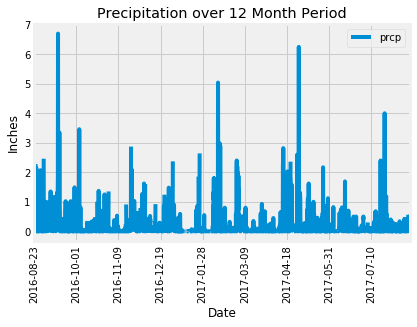

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(title="Precipitation over 12 Month Period", rot='vertical')
plt.tight_layout
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show;


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
stations_unique=(session.query(Measurement.station)
                .group_by(Measurement.station).count())
stations_unique

9

In [20]:
query=session.query(Measurement.station).distinct()
for row in query:
    print(row.station)

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = (session.query(Measurement.station, func.count(Measurement.station).label('counts'))
    .group_by(Measurement.station)
    .order_by(desc('counts')) 
    .all())
query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
active_averages = (session.query(*sel)
                   .filter(Measurement.station== 'USC00519281')
                   .all())
active_averages

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel= [Measurement.station,
       Measurement.tobs]
query=((session.query(*sel)
        .filter(Measurement.date >= '2016-08-23')
        .filter(Measurement.station=='USC00519281')
        .all()))
df = pd.DataFrame(query, columns=['station', 'tobs'])
df=df.set_index('station')
df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


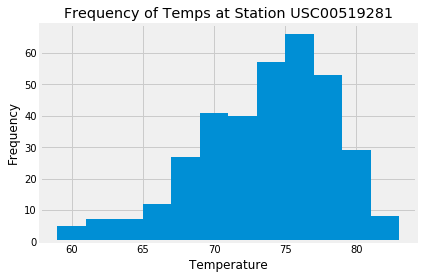

In [24]:
df.hist(column='tobs', bins=12)
plt.title("Frequency of Temps at Station USC00519281")
plt.ylabel("Frequency")
plt.xlabel("Temperature");